In [2]:
import pandas as pd
import numpy as np
import glob

import os
from scipy.interpolate import interp1d
import re

In [3]:
#ForKK Local
DataPath = "./XC-CleanedData/**/*.csv"
FilteredDataPath = "./GeneratedData/"
FilteredDataPathCenterlines = "./GeneratedData/Centerlines"

# Calculate Centerlines

In [4]:
ListOfScenarios=["CP1","CP2","CP3","CP5","CP6","CP7","CP8"]
MaxDistance=35
window_size = 5  # This can be changed depending on how much smoothing you want
kernel = np.ones(window_size) / window_size
column_types = {'ScenarioTime': 'float64',
                'AccelA': 'float64',
                'AccelB': 'float64',
                'SteerA': 'float64',
                'SteerB': 'float64',
                'HeadPosXA': 'float64',
                'HeadPosYA': 'float64',
                'HeadPosZA': 'float64',
                'HeadPosXB': 'float64',
                'HeadPosYB': 'float64',
                'HeadPosZB': 'float64',
                'HeadrotYA': 'float64',
                'HeadrotYB': 'float64',
                }

required_columns = set(column_types.keys())

# Initialize a dictionary to hold data by scenario
data_by_scenario = {}
data_by_scenario_location = {}

In [4]:
def separate_letters_numbers(s):
    match = re.match(r"([a-zA-Z]+)([0-9]+)", s)
    if match:
        letters, numbers = match.groups()
        return letters.upper(), numbers
    else:
        return s, ""

In [5]:
# Set options to avoid chained assignment warnings
pd.options.mode.chained_assignment = None

CSVFiles = glob.glob(DataPath, recursive=True)

# Read and organize data by scenario    
for val in CSVFiles:
  Scenario = os.path.basename(val).split('-')[1].split('_')[0]
  Location, Run = separate_letters_numbers(os.path.basename(val).split('-')[2].split('_')[0])
  if(Scenario in ListOfScenarios):
    try:
      df = pd.read_csv(val,sep=';',dtype=column_types)
    except Exception as e:
      print(f"An error occurred while reading {Scenario} at {Location} Run {Run}: {e}")
      continue
    is_columns = set(df.columns)
    if not required_columns.issubset(is_columns):
      missing_columns = required_columns - is_columns
      print(f"DataFrame is missing columns: {missing_columns} {Scenario} at {Location} Run {Run}")
      continue
    # Head-Center Distance
    df['A_Head_Center_Distance'] = np.sqrt(df['HeadPosXA']**2 + df['HeadPosYA']**2 + df['HeadPosZA']**2)
    df['B_Head_Center_Distance'] = np.sqrt(df['HeadPosXB']**2 + df['HeadPosYB']**2 + df['HeadPosZB']**2)
    # Define dataframe inner area to be within a radius of MaxDistance = 35
    innerArea = df.loc[(df['A_Head_Center_Distance'] < MaxDistance)
                        & (df['B_Head_Center_Distance'] < MaxDistance)].copy().reset_index()
    if innerArea.shape[0] == 0:
        print("Skipping: ", Scenario, Location, Run)
        continue
    # Append data to the corresponding scenario
    if Scenario not in data_by_scenario:
      data_by_scenario[Scenario] = []
    data_by_scenario[Scenario].append(df)
    # Append data to the corresponding scenario and location
    if Scenario not in data_by_scenario_location:
        data_by_scenario_location[Scenario] = {}
    if Location not in data_by_scenario_location[Scenario]:
        data_by_scenario_location[Scenario][Location] = []
    data_by_scenario_location[Scenario][Location].append(innerArea)

Skipping:  CP5 NYC 1
Skipping:  CP2 NYC 1
Skipping:  CP1 NYC 1
Skipping:  CP1 NYC 25
Skipping:  CP1 ISR 13
Skipping:  CP1 NYC 9
Skipping:  CP5 ISR 39
Skipping:  CP5 ISR 38
Skipping:  CP2 ISR 38
Skipping:  CP3 NYC 2
Skipping:  CP2 NYC 10
Skipping:  CP6 ISR 11
DataFrame is missing columns: {'AccelB', 'HeadrotYA', 'HeadPosYA', 'SteerA', 'HeadPosXA', 'HeadPosXB', 'HeadrotYB', 'AccelA', 'SteerB', 'HeadPosZB', 'ScenarioTime', 'HeadPosZA', 'HeadPosYB'} CP1 at NYC Run 42
Skipping:  CP3 NYC 11
Skipping:  CP7 NYC 16
Skipping:  CP7 NYC 29
Skipping:  CP5 NYC 3
Skipping:  CP3 NYC 4
Skipping:  CP5 ITH 3
Skipping:  CP1 NYC 34
Skipping:  CP1 NYC 34
An error occurred while reading CP1 at NYC Run 34: could not convert string to float: ''
An error occurred while reading CP7 at NYC Run 33: could not convert string to float: ''
An error occurred while reading CP2 at NYC Run 33: could not convert string to float: ''
Skipping:  CP6 NYC 14
Skipping:  CP6 ISR 34
Skipping:  CP5 ISR 03


In [1]:
innerArea

NameError: name 'innerArea' is not defined

In [9]:
# Functions for centerline

# Function to resample a path to a fixed number of points
def resample_path(df, car='A', num_points=400):
    col_x = 'HeadPosX' + car
    col_y = 'HeadPosZ' + car
    if col_x not in df.columns or col_y not in df.columns:
        raise KeyError(f"Columns '{col_x}' and '{col_y}' are required in the DataFrame")
    
    # Calculate the cumulative distance along the path
    distances = np.sqrt(np.diff(df[col_x])**2 + np.diff(df[col_y])**2)
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    
    # Interpolation functions for X and Y coordinates
    interp_func_x = interp1d(cumulative_distances, df[col_x], kind='linear')
    interp_func_y = interp1d(cumulative_distances, df[col_y], kind='linear')
    
    # New distance values for resampling
    new_distances = np.linspace(0, cumulative_distances[-1], num=num_points)
    
    # Interpolated X and Y coordinates
    resampled_x = interp_func_x(new_distances)
    resampled_y = interp_func_y(new_distances)
    
    return pd.DataFrame({col_x: resampled_x, col_y: resampled_y})
    
# Function to compute the median start and end points
def compute_median_start_end(paths, col_x, col_y):
    start_points = pd.DataFrame({col_x: [path[col_x].iloc[0] for path in paths], 
                                 col_y: [path[col_y].iloc[0] for path in paths]})
    end_points = pd.DataFrame({col_x: [path[col_x].iloc[-1] for path in paths], 
                               col_y: [path[col_y].iloc[-1] for path in paths]})
    median_start = start_points.median()
    median_end = end_points.median()
    return median_start, median_end    

# Function to detect outliers based on start and end points
def detect_outliers_by_start_end(paths, median_start, median_end, col_x, col_y, threshold):
    cleaned_paths = []
    for path in paths:
        start_distance = np.sqrt((path[col_x].iloc[0] - median_start[col_x])**2 + (path[col_y].iloc[0] - median_start[col_y])**2)
        end_distance = np.sqrt((path[col_x].iloc[-1] - median_end[col_x])**2 + (path[col_y].iloc[-1] - median_end[col_y])**2)
        if start_distance <= threshold and end_distance <= threshold:
            cleaned_paths.append(path)
    return cleaned_paths

## By Scenarios and Locations

In [10]:
# Resample paths for each scenario and location
resampled_data_by_scenario_location_A = {}
resampled_data_by_scenario_location_B = {}

for scenario, locations in data_by_scenario_location.items():
    resampled_data_by_scenario_location_A[scenario] = {}
    resampled_data_by_scenario_location_B[scenario] = {}
    for location, runs in locations.items():
        resampled_runs_A = [resample_path(run, car='A') for run in runs]
        resampled_runs_B = [resample_path(run, car='B') for run in runs]
        resampled_data_by_scenario_location_A[scenario][location] = resampled_runs_A
        resampled_data_by_scenario_location_B[scenario][location] = resampled_runs_B

# Remove outliers for each scenario and location
cleaned_data_by_scenario_location_A = {}
cleaned_data_by_scenario_location_B = {}

threshold = 10

for scenario, locations in resampled_data_by_scenario_location_A.items():
    cleaned_data_by_scenario_location_A[scenario] = {}
    cleaned_data_by_scenario_location_B[scenario] = {}
    for location, resampled_runs_A in locations.items():
        resampled_runs_B = resampled_data_by_scenario_location_B[scenario][location]
        median_start_A, median_end_A = compute_median_start_end(resampled_runs_A, 'HeadPosXA', 'HeadPosZA')
        median_start_B, median_end_B = compute_median_start_end(resampled_runs_B, 'HeadPosXB', 'HeadPosZB')
        cleaned_paths_A = detect_outliers_by_start_end(resampled_runs_A, median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
        cleaned_paths_B = detect_outliers_by_start_end(resampled_runs_B, median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
        cleaned_data_by_scenario_location_A[scenario][location] = cleaned_paths_A
        cleaned_data_by_scenario_location_B[scenario][location] = cleaned_paths_B

# Compute the centerline for each scenario and location after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, locations in cleaned_data_by_scenario_location_A.items():
    centerlines_A[scenario] = {}
    centerlines_B[scenario] = {}
    for location, cleaned_runs_A in locations.items():
        combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
        average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
        centerlines_A[scenario][location] = average_path_A

for scenario, locations in cleaned_data_by_scenario_location_B.items():
    for location, cleaned_runs_B in locations.items():
        combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
        average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
        centerlines_B[scenario][location] = average_path_B

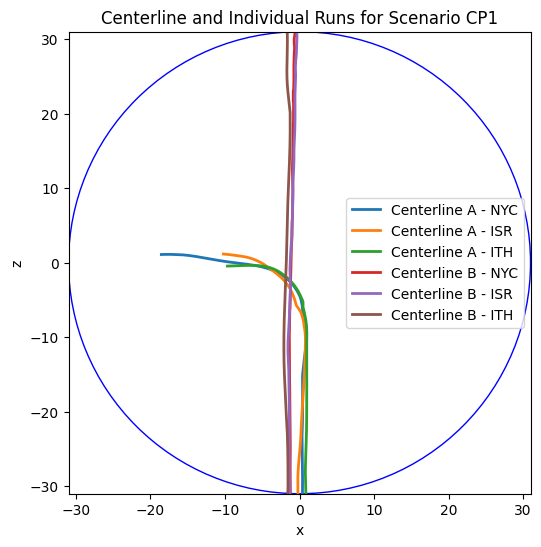

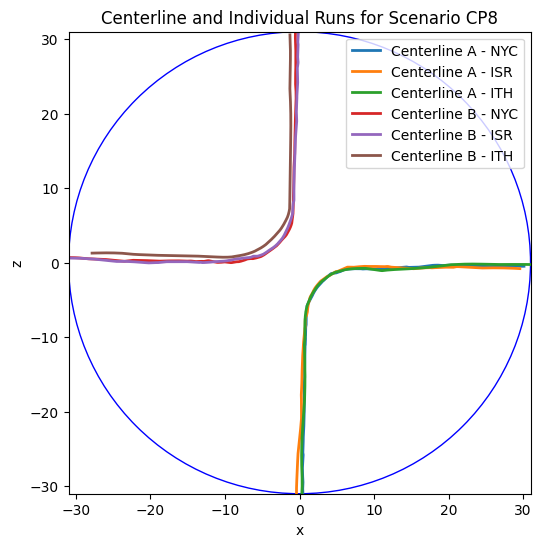

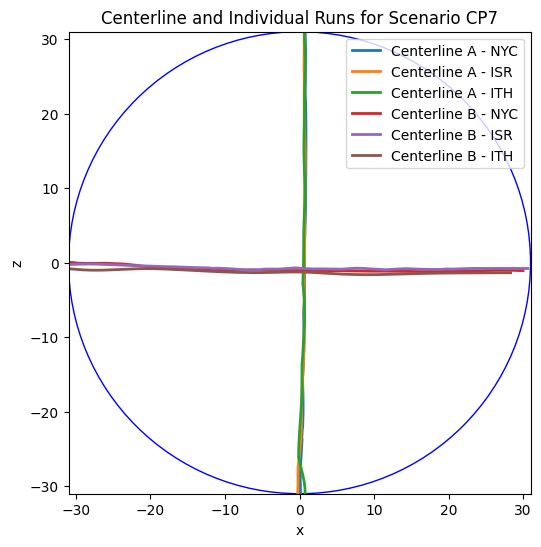

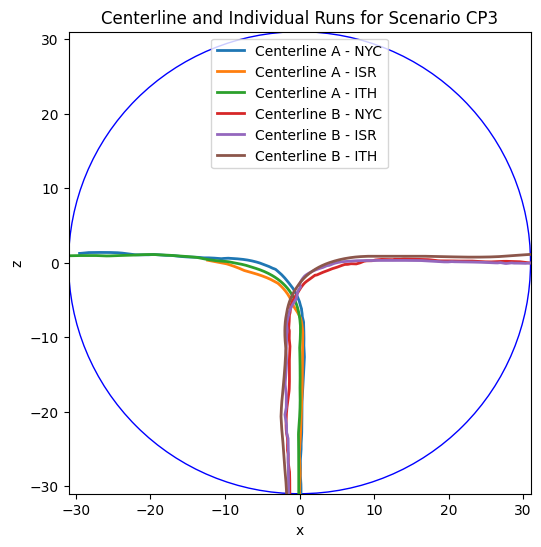

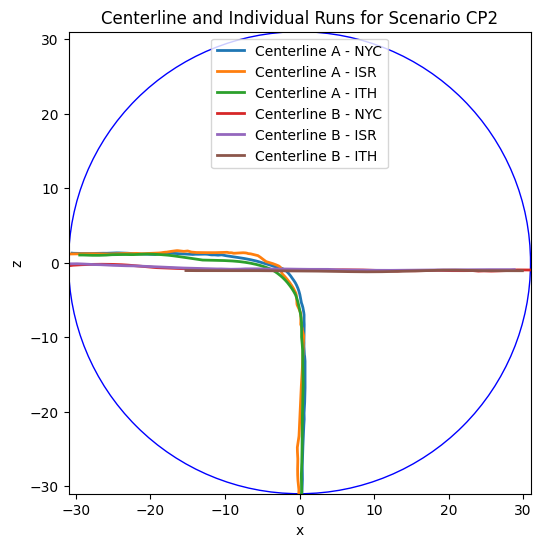

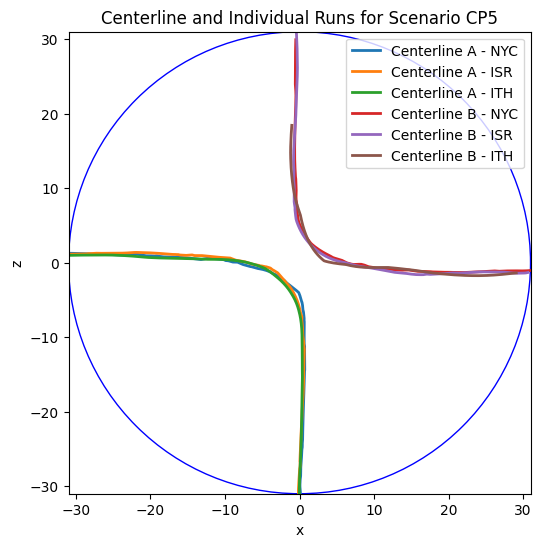

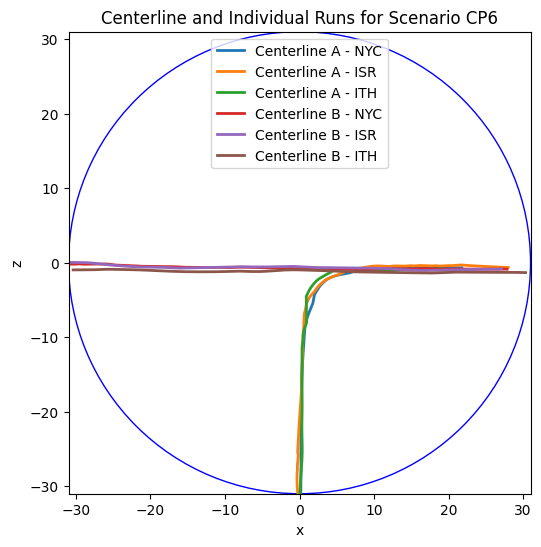

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario and location
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # # Plot individual runs for car A
    # for location, runs in cleaned_data_by_scenario_location_A[scenario].items():
    #     for run in runs:
            # plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # # Plot individual runs for car B
    # for location, runs in cleaned_data_by_scenario_location_B[scenario].items():
    #     for run in runs:
    #         plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A by location
    for location, centerline in centerlines_A[scenario].items():
        plt.plot(centerline['HeadPosXA'], centerline['HeadPosZA'], linewidth=2, label=f'Centerline A - {location}')
    
    # Plot the centerline for car B by location
    for location, centerline in centerlines_B[scenario].items():
        plt.plot(centerline['HeadPosXB'], centerline['HeadPosZB'], linewidth=2, label=f'Centerline B - {location}')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()


## By Scenarios only

In [12]:
# Resample paths for each scenario
resampled_data_by_scenario_A = {}
resampled_data_by_scenario_B = {}

for scenario, runs in data_by_scenario.items():
    resampled_runs_A = [resample_path(run,car='A') for run in runs]
    resampled_runs_B = [resample_path(run,car='B') for run in runs]
    resampled_data_by_scenario_A[scenario] = resampled_runs_A
    resampled_data_by_scenario_B[scenario] = resampled_runs_B

# Display the resampled data structure
print(resampled_data_by_scenario_A.keys())

# Remove outliers for each scenario
cleaned_data_by_scenario_A = {}
cleaned_data_by_scenario_B = {}

threshold = 10

for scenario in resampled_data_by_scenario_A.keys():
    median_start_A, median_end_A = compute_median_start_end(resampled_data_by_scenario_A[scenario], 'HeadPosXA', 'HeadPosZA')
    median_start_B, median_end_B = compute_median_start_end(resampled_data_by_scenario_B[scenario], 'HeadPosXB', 'HeadPosZB')
    cleaned_paths_A = detect_outliers_by_start_end(resampled_data_by_scenario_A[scenario], median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
    cleaned_paths_B = detect_outliers_by_start_end(resampled_data_by_scenario_B[scenario], median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
    cleaned_data_by_scenario_A[scenario] = cleaned_paths_A
    cleaned_data_by_scenario_B[scenario] = cleaned_paths_B
    
# Compute the centerline for each scenario and each car after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, cleaned_runs_A in cleaned_data_by_scenario_A.items():
    combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
    average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
    centerlines_A[scenario] = average_path_A

for scenario, cleaned_runs_B in cleaned_data_by_scenario_B.items():
    combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
    average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
    centerlines_B[scenario] = average_path_B

dict_keys(['CP1', 'CP8', 'CP7', 'CP3', 'CP2', 'CP5', 'CP6'])


In [13]:
def save_centerlines(centerlines, scenario, car_type):
    # Create the full path for the file
    file_path = os.path.join(FilteredDataPathCenterlines, f'centerline_{scenario}_{car_type}.feather')
    
    # Save the DataFrame to a Feather file
    centerlines.to_feather(file_path)
    print(f"Saved centerline for {scenario} ({car_type}) to {file_path}")

# Save centerlines for car A
for scenario, centerline_df in centerlines_A.items():
    save_centerlines(centerline_df, scenario, 'A')

# Save centerlines for car B
for scenario, centerline_df in centerlines_B.items():
    save_centerlines(centerline_df, scenario, 'B')

Saved centerline for CP1 (A) to ./GeneratedData/Centerlines/centerline_CP1_A.feather
Saved centerline for CP8 (A) to ./GeneratedData/Centerlines/centerline_CP8_A.feather
Saved centerline for CP7 (A) to ./GeneratedData/Centerlines/centerline_CP7_A.feather
Saved centerline for CP3 (A) to ./GeneratedData/Centerlines/centerline_CP3_A.feather
Saved centerline for CP2 (A) to ./GeneratedData/Centerlines/centerline_CP2_A.feather
Saved centerline for CP5 (A) to ./GeneratedData/Centerlines/centerline_CP5_A.feather
Saved centerline for CP6 (A) to ./GeneratedData/Centerlines/centerline_CP6_A.feather
Saved centerline for CP1 (B) to ./GeneratedData/Centerlines/centerline_CP1_B.feather
Saved centerline for CP8 (B) to ./GeneratedData/Centerlines/centerline_CP8_B.feather
Saved centerline for CP7 (B) to ./GeneratedData/Centerlines/centerline_CP7_B.feather
Saved centerline for CP3 (B) to ./GeneratedData/Centerlines/centerline_CP3_B.feather
Saved centerline for CP2 (B) to ./GeneratedData/Centerlines/cente

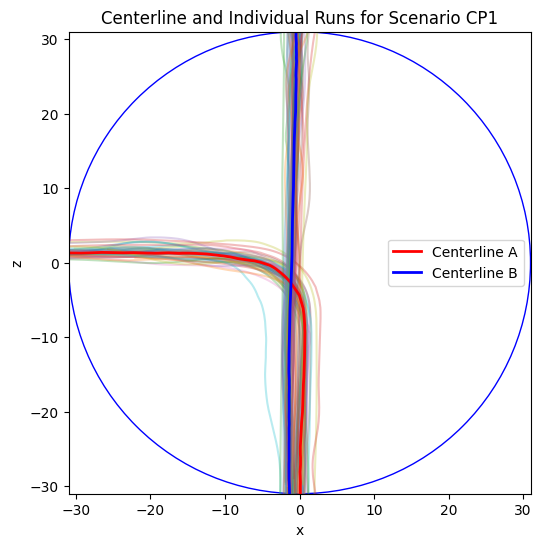

CP1: 42 Runs for A, 64 Runs for B


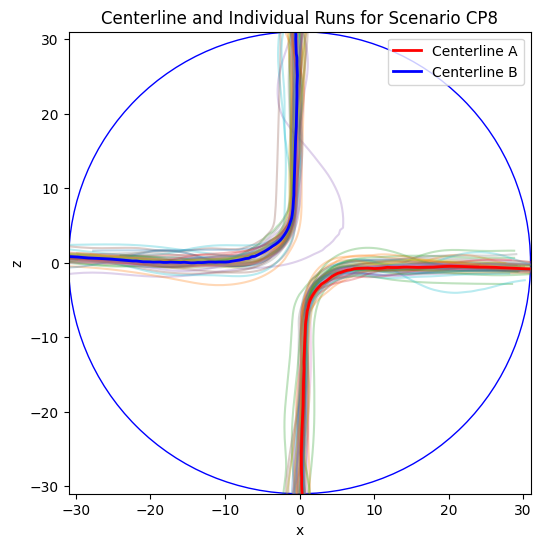

CP8: 54 Runs for A, 55 Runs for B


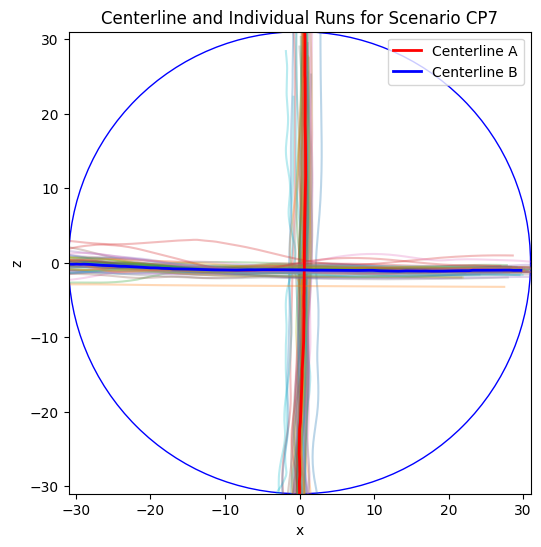

CP7: 62 Runs for A, 55 Runs for B


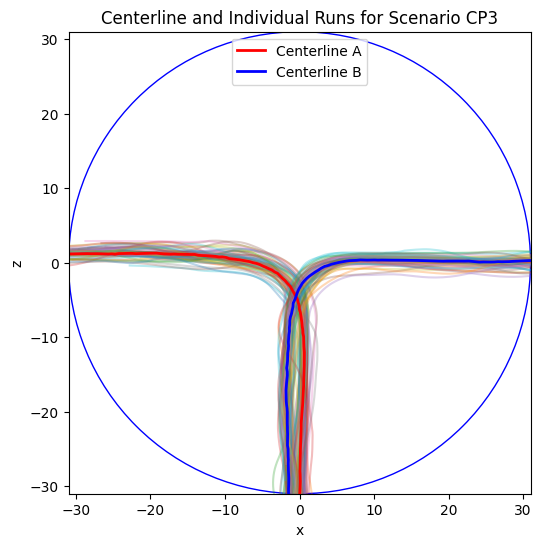

CP3: 61 Runs for A, 49 Runs for B


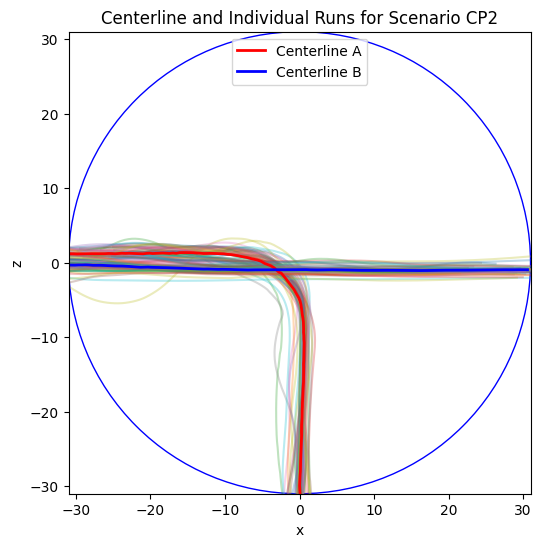

CP2: 51 Runs for A, 62 Runs for B


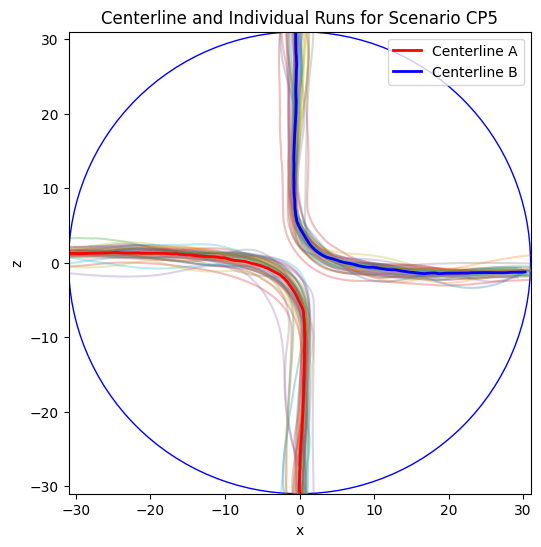

CP5: 49 Runs for A, 46 Runs for B


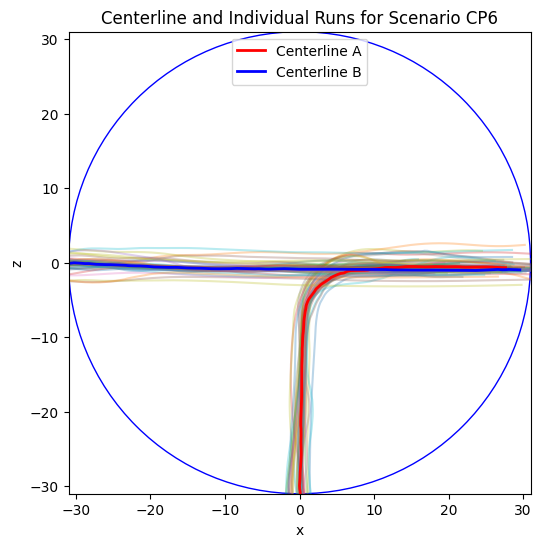

CP6: 40 Runs for A, 45 Runs for B


In [14]:
# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot individual runs for car A
    counter_A = 0
    for run in cleaned_data_by_scenario_A[scenario]:
        counter_A += 1
        plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # Plot individual runs for car B
    counter_B = 0
    for run in cleaned_data_by_scenario_B[scenario]:
        counter_B += 1
        plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A
    plt.plot(centerlines_A[scenario]['HeadPosXA'], centerlines_A[scenario]['HeadPosZA'], color='red', linewidth=2, label='Centerline A')
    
    # Plot the centerline for car B
    plt.plot(centerlines_B[scenario]['HeadPosXB'], centerlines_B[scenario]['HeadPosZB'], color='blue', linewidth=2, label='Centerline B')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()
    print(f"{scenario}: {counter_A} Runs for A, {counter_B} Runs for B")

In [15]:
centerlines_A['CP1']

,Point_ID,HeadPosXA,HeadPosZA
0,0,80.731100,-75.542950
1,1,80.255503,-75.543001
2,2,79.783410,-75.548173
3,3,79.314733,-75.556924
4,4,78.840176,-75.560793
...,...,...,...
395,395,-32.133647,1.287220
396,396,-32.604043,1.305303
397,397,-33.074446,1.310835
398,398,-33.544851,1.307115
